In [1]:
import os
import glob
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
# ─── Config ─────────────────────────────────────────
RAW_FOLDER = 'Cleaned Data'
LOOK_BACK = 60
FORECAST_HORIZON = 120
FREQ = '10s'

CORE_KEEP = ['time', 'latitude', 'longitude', 'depth', 'c_heading']
STD_MAP = {
    'time': 'TIMESTAMP',
    'latitude': 'LAT',
    'longitude': 'LONG',
    'depth': 'DEPTH',
    'c_heading': 'HEADING'
}

# ─── 1) Load & concatenate ─────────────────────────
paths = sorted(glob.glob(os.path.join(RAW_FOLDER, '*.csv')))
if not paths:
    raise FileNotFoundError(f"No CSVs found in {RAW_FOLDER}")

frames = []
for p in paths:
    try:
        df = pd.read_csv(p, usecols=lambda c: c in CORE_KEEP)
        df = df.rename(columns=STD_MAP)
        df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'], utc=True, errors='coerce').dt.tz_convert(None)
        df = df.dropna(subset=['TIMESTAMP'])
        df = df.sort_values('TIMESTAMP')
        df = df.loc[~df['TIMESTAMP'].duplicated(keep='first')]
        frames.append(df)
    except Exception as e:
        print(f"Error processing {p}: {str(e)}")

if not frames:
    raise ValueError("No valid data loaded from any files")

all_df = pd.concat(frames, ignore_index=True)
print("After concat, columns:", all_df.columns.tolist())
print("Time range:", all_df['TIMESTAMP'].min(), "to", all_df['TIMESTAMP'].max())

# ─── 2) Set index & resample ───────────────────────
# Remove duplicates and set index
all_df = all_df.drop_duplicates(subset=['TIMESTAMP'], keep='first')
all_df = all_df.set_index('TIMESTAMP').sort_index()

# Verify index
print("\n── Index Verification ──")
print(f"Index type: {type(all_df.index)}")
print(f"Sample index: {all_df.index[:5]}")
print(f"Index duplicates: {all_df.index.duplicated().sum()}")
print(f"Index sorted: {all_df.index.is_monotonic_increasing}")
assert all_df.index.is_unique, "Duplicate indices found!"

# Resample with gap analysis
print("\n── Resampling with Aggregation ──")
original_count = len(all_df)
resampled = all_df.resample(FREQ).mean()
print(f"Resampled from {len(all_df)} to {len(resampled)} points")
print(f"Missing values after resample: {resampled.isna().sum()}")

# ─── 3) Impute gaps ────────────────────────────────
print("\n── Imputation ──")
imputed = resampled.interpolate(
    method='time',
    limit=FORECAST_HORIZON,
    limit_direction='both'
)
null_mask = resampled['LAT'].isnull().astype(int)
gap_starts = (null_mask.diff() == 1).fillna(False)
gap_ids = gap_starts.cumsum()
gap_sizes = null_mask.groupby(gap_ids).sum()

if not gap_sizes.empty:
    print("Gap statistics:")
    print(gap_sizes.value_counts().sort_index().head(20))

# Final cleanup
imputed = imputed.dropna()
print(f"Final data points: {len(imputed)}")
# Detect deployment gaps > 1 day
big_gaps = (imputed.index.to_series().diff() > pd.Timedelta(days=1))
if big_gaps.any():
    print(f"Found {big_gaps.sum()} large gaps between deployments")
    # Consider splitting data into separate deployments



# ─── 4) Normalize ──────────────────────────────────
num_cols = ['LAT', 'LONG', 'DEPTH', 'HEADING']
scaler = MinMaxScaler()
imputed[num_cols] = scaler.fit_transform(imputed[num_cols])
print("\nNormalization complete")
print("Value ranges:")
print(imputed.agg(['min', 'max']))

# ─── 5) Create sequences ────────────────────────────
def make_sequences(df, look_back, horizon, feat_cols):
    data = df[feat_cols].values
    sequences = []
    targets = []
    for i in range(len(df) - look_back - horizon + 1):
        sequences.append(data[i:i+look_back])
        targets.append(data[i+look_back:i+look_back+horizon])
    return np.array(sequences), np.array(targets)

X, y = make_sequences(imputed.reset_index(), LOOK_BACK, FORECAST_HORIZON, num_cols)
print(f"\nX shape: {X.shape} (samples, look_back, features)")
print(f"y shape: {y.shape} (samples, horizon, features)")

# ─── Verification ───────────────────────────────────
print("\n── Final Checks ──")
print(f"Total time span: {(imputed.index[-1] - imputed.index[0]).total_seconds()/3600:.2f} hours")
print(f"Expected sequences: {len(imputed) - LOOK_BACK - FORECAST_HORIZON + 1}")
print(f"Actual sequences: {len(X)}")

print("\n✅ Preprocessing complete. Ready for model training.")

After concat, columns: ['TIMESTAMP', 'LAT', 'LONG', 'DEPTH', 'HEADING']
Time range: 2023-09-13 00:22:52 to 2025-06-17 14:32:47

── Index Verification ──
Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Sample index: DatetimeIndex(['2023-09-13 00:22:52', '2023-09-13 00:23:04',
               '2023-09-13 00:23:16', '2023-09-13 00:23:28',
               '2023-09-13 00:23:40'],
              dtype='datetime64[ns]', name='TIMESTAMP', freq=None)
Index duplicates: 0
Index sorted: True

── Resampling with Aggregation ──
Resampled from 701512 to 5560620 points
Missing values after resample: LAT        5378511
LONG       5378511
DEPTH      5378511
HEADING    5560513
dtype: int64

── Imputation ──
Gap statistics:
LAT
0         1
1      1074
2     18938
3      1292
4       227
5        81
6        40
7        42
8       134
9        94
10       48
11       32
12       18
13       32
14       13
15       16
16       36
17       36
18       27
19       33
Name: count, dtype: int64
F

Model Architecture

In [5]:
import os
import numpy as np
import tensorflow as tf
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Bidirectional, TimeDistributed
#from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
#from tensorflow.keras.layers import RepeatVector
import matplotlib.pyplot as plt

# ─── Model Architecture (Fixed) ────────────────────────────────────────────────
def build_glider_model(input_shape: tuple, output_steps: int, 
                      output_features: int, model_type: str = 'LSTM') -> tf.keras.Sequential:
    """
    Builds and compiles an LSTM or GRU model for glider trajectory prediction.
    """
    model = tf.keras.Sequential(name="glider_seq2seq")
    
    # Encoder layers
    if model_type == 'LSTM':
        model.add(tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(128, return_sequences=True),
            input_shape=input_shape
        ))
        model.add(tf.keras.layers.Dropout(0.3))
        model.add(tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(64, return_sequences=False)
        ))
    elif model_type == 'GRU':
        model.add(tf.keras.layers.Bidirectional(
            tf.keras.layers.GRU(128, return_sequences=True),
            input_shape=input_shape
        ))
        model.add(tf.keras.layers.Dropout(0.3))
        model.add(tf.keras.layers.Bidirectional(
            tf.keras.layers.GRU(64, return_sequences=False)
        ))
    else:
        raise ValueError("model_type must be 'LSTM' or 'GRU'")

    
    model.add(tf.keras.layers.Dropout(0.3))

    
    # Repeat vector to match output sequence length
    model.add(tf.keras.layers.RepeatVector(output_steps))  # repeats the context vector
    
    # Decoder layers
    if model_type == 'LSTM':
        model.add(tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(64, return_sequences=True)
        ))
    else:  # GRU
        model.add(tf.keras.layers.Bidirectional(
            tf.keras.layers.GRU(64, return_sequences=True)
        ))

    
    # Time-distributed dense layer
    model.add(tf.keras.layers.TimeDistributed(
        tf.keras.layers.Dense(32, activation='relu')
    ))  # applies the same Dense to each timestep :contentReference[oaicite:4]{index=4}
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.TimeDistributed(
        tf.keras.layers.Dense(output_features, activation='linear')
    ))

    # ── Compile ───────────────────────────────────────────────
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),  # Adam optimizer :contentReference[oaicite:5]{index=5}
        loss='mse',
        metrics=['mae']
    )

    model.summary()
    return model


# ─── Model Training ────────────────────────────────────────────────────
def train_glider_model(
    model: tf.keras.Sequential,
    X_train, y_train,
    X_val, y_val,
    epochs: int = 100,
    batch_size: int = 64,
    model_path: str = 'glider_model.keras'
):
    """
    Trains the model with enhanced callbacks and model checkpointing.
    """
    print("\n--- Starting Model Training ---")
    
    # Callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=model_path,
            monitor='val_loss',
            save_best_only=True
        )
    ]
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )

    return history

'\n# ─── Main Execution Flow ──────────────────────────────────────────────\ndef main():\n    # Configuration\n    LOOK_BACK = 60       # Past time steps (1 hour at 1-min intervals)\n    FORECAST_HORIZON = 120  # Future time steps (2 hours)\n    FEATURES = 4         # LAT, LONG, DEPTH, HEADING\n    MODEL_TYPE = \'LSTM\'  # or \'GRU\'\n    TEST_SIZE = 0.2      # Validation set size\n    EPOCHS = 150\n    BATCH_SIZE = 128\n    MODEL_PATH = \'glider_model.keras\'\n    \n    # Placeholder for your data - replace with actual loading\n    # X, y = load_your_preprocessed_data()\n    print("Simulating data for demonstration...")\n    X = np.random.randn(1000, LOOK_BACK, FEATURES)\n    y = np.random.randn(1000, FORECAST_HORIZON, FEATURES)\n    \n    print(f"Input shape: {X.shape}, Target shape: {y.shape}")\n    \n    # Split into train/validation sets (preserve temporal order)\n    split_idx = int(len(X) * (1 - TEST_SIZE))\n    X_train, y_train = X[:split_idx], y[:split_idx]\n    X_val, y_val =

In [3]:
import tensorflow as tf
print(tf.__version__)

2.18.1


TensorFlow: 2.18.1
Using CPU
Simulating data for demonstration...
Input shape: (1000, 60, 4), Target shape: (1000, 120, 4)


Model: "glider_seq2seq"

┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃                 ┃ Output     ┃ Param ┃
┃ Layer (type)    ┃ Shape      ┃     # ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ bidirectional_… │ (None, 60, │ 136,… │
│ (Bidirectional) │ 256)       │       │
├─────────────────┼────────────┼───────┤
│ dropout_18      │ (None, 60, │     0 │
│ (Dropout)       │ 256)       │       │
├─────────────────┼────────────┼───────┤
│ bidirectional_… │ (None,     │ 164,… │
│ (Bidirectional) │ 128)       │       │
├─────────────────┼────────────┼───────┤
│ dropout_19      │ (None,     │     0 │
│ (Dropout)       │ 128)       │       │
├─────────────────┼────────────┼───────┤
│ repeat_vector_6 │ (None,     │     0 │
│ (RepeatVector)  │ 120, 128)  │       │
├─────────────────┼────────────┼───────┤
│ bidirectional_… │ (None,     │ 98,8… │
│ (Bidirectional) │ 120, 128)  │       │
├─────────────────┼────────────┼───────┤
│ time_distribut… │ (None,     │ 4,128 │
│ (TimeDistribut… │ 120, 32)   │       │
├─────────────────┼────────────┼───────┤
│ dropout_20      │ (None,     │     0 │
│ (Dropout)       │ 120, 32)   │       │
├─────────────────┼────────────┼───────┤
│ time_distribut… │ (None,     │   132 │
│ (TimeDistribut… │ 120, 4)    │       │
└─────────────────┴────────────┴───────┘

 Total params: 403,620 (1.54 MB)

 Trainable params: 403,620 (1.54 MB)

 Non-trainable params: 0 (0.00 B)


--- Starting Model Training ---
Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - loss: 1.0009 - mae: 0.7987 - val_loss: 1.0042 - val_mae: 0.7992 - learning_rate: 0.0010
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 1.0003 - mae: 0.7980 - val_loss: 1.0041 - val_mae: 0.7992 - learning_rate: 0.0010
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 1.0023 - mae: 0.7985 - val_loss: 1.0041 - val_mae: 0.7992 - learning_rate: 0.0010
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 1.0008 - mae: 0.7982 - val_loss: 1.0040 - val_mae: 0.7992 - learning_rate: 0.0010
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 1.0007 - mae: 0.7985 - val_loss: 1.0040 - val_mae: 0.7992 - learning_rate: 0.0010
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - loss: 1.0031 - mae: 0.7990 - val_loss: 1.0041 - val_mae: 0.7993 - learning_rate: 0.0010
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 1.0017 - mae: 0.7985 - val_loss: 1.0042 - val_mae: 0.7993 - learning_rate: 0.0010
Epoch

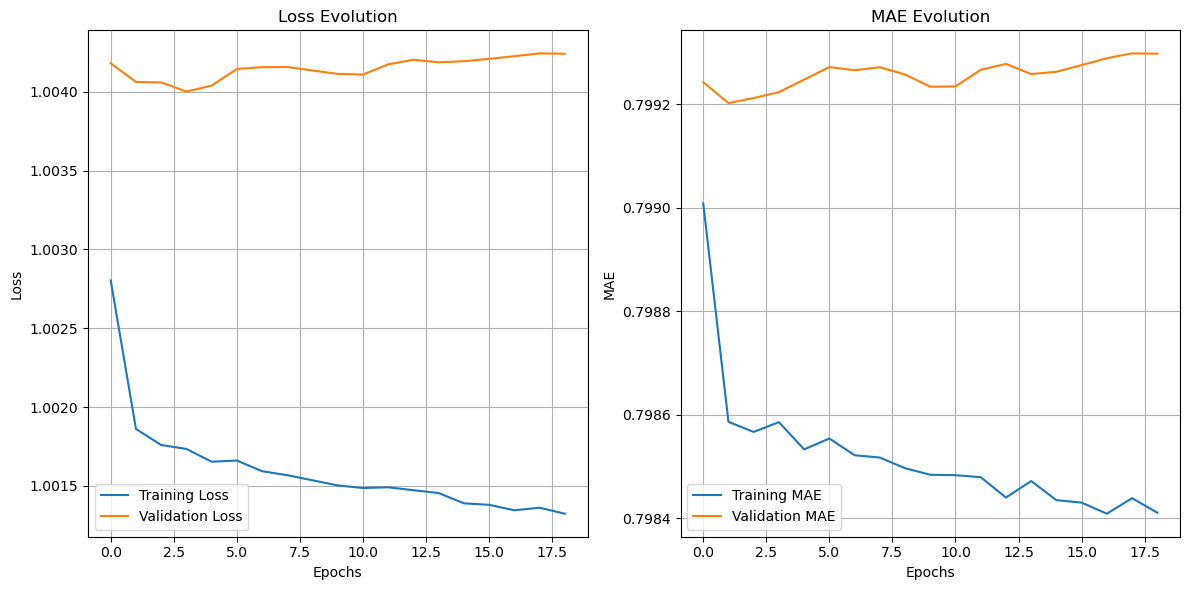


--- Model Evaluation ---
Validation Loss: 1.0040, MAE: 0.7992

Final model saved to glider_model.keras


In [12]:
def plot_training_history(history):
    """Plots training and validation loss curves."""
    plt.figure(figsize=(12, 6))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Evolution')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('MAE Evolution')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()


MODEL_PATH = 'glider_model.keras'


def main():
    
    LOOK_BACK = 60
    FORECAST_HORIZON = 120
    FEATURES = 4
    TEST_SPLIT = 0.2

    # Load your preprocessed X, y here
    # X, y = load_preprocessed_data(...)
    print("Simulating data for demonstration...")
    X = np.random.randn(1000, LOOK_BACK, FEATURES)
    y = np.random.randn(1000, FORECAST_HORIZON, FEATURES)
    
    print(f"Input shape: {X.shape}, Target shape: {y.shape}")
    
    # Example split (preserve time order)
    split = int(len(X) * (1 - TEST_SPLIT))
    X_train, y_train = X[:split], y[:split]
    X_val,   y_val   = X[split:], y[split:]

    # Build & train
    model = build_glider_model(
        input_shape=(LOOK_BACK, FEATURES),
        output_steps=FORECAST_HORIZON,
        output_features=FEATURES,
        model_type='LSTM'
    )
    history = train_glider_model(
        model, X_train, y_train, X_val, y_val,
        epochs=30,
        batch_size=128,
        model_path='glider_model.keras'
    )

    return model, history, X_val, y_val
    

if __name__ == "__main__":
    # Check TF version
    print("TensorFlow:", tf.__version__)
    # Enable GPU memory growth if available
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU enabled")
    else:
        print("Using CPU")

#*****************************************
    
    model, history, X_val, y_val = main()
      # Plot training history
    plot_training_history(history)
    # Evaluate final model
    print("\n--- Model Evaluation ---")
    val_loss, val_mae = model.evaluate(X_val, y_val, verbose=0)
    print(f"Validation Loss: {val_loss:.4f}, MAE: {val_mae:.4f}")
    # Save final model
    model.save(MODEL_PATH)
    print(f"\nFinal model saved to {MODEL_PATH}")

--- Ignore below steps  ---------------

In [2]:
import os
import glob
import io
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from typing import List, Tuple

# ─── Config ─────────────────────────────────────────
RAW_FOLDER      = 'Cleaned Data'       # your folder of pre-cleaned CSVs
LOOK_BACK       = 60                   # past minutes
FORECAST_HORIZON= 120                  # future minutes
FREQ            = '1min'               # resample at 1-minute intervals

# Columns to keep and their rename
CORE_KEEP = ['time', 'latitude', 'longitude', 'depth', 'c_heading']
STD_MAP   = {'time':'TIMESTAMP',
             'latitude':'LAT',
             'longitude':'LONG',
             'depth':'DEPTH',
             'c_heading':'HEADING'}

# ─── 1) Load & concatenate ─────────────────────────
paths = sorted(glob.glob(os.path.join(RAW_FOLDER,'*.csv')))
if not paths:
    raise FileNotFoundError(f"No CSVs found in {RAW_FOLDER}")

frames = []
for p in paths:
    df = pd.read_csv(p, usecols=lambda c: c in CORE_KEEP)
    df = df.rename(columns=STD_MAP)
    # parse time
    df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'], utc=True, errors='coerce').dt.tz_convert(None)  # Remove timezone info
    # drop rows where time failed to parse
    df = df.dropna(subset=['TIMESTAMP'])
    df = df.sort_values('TIMESTAMP')
    # remove duplicate timestamps
    df = df.loc[~df['TIMESTAMP'].duplicated(keep='first')]
    frames.append(df)
all_df = pd.concat(frames, ignore_index=True)
print("After concat, columns:", all_df.columns.tolist())

all_df = all_df.drop_duplicates(subset=['TIMESTAMP'], keep='first')
#assert isinstance(all_df.index, pd.DatetimeIndex)

print("Loaded rows:", len(all_df))

# ─── 2) Set index & resample ───────────────────────
all_df = all_df.set_index('TIMESTAMP').sort_index()
# ensure index is DatetimeIndex
#all_df = df[~df.index.duplicated(keep='first')]  # Remove duplicate indices
assert df.index.is_unique, "Index still contains duplicates"
#assert isinstance(all_df.index, pd.DatetimeIndex)
# introduce uniform 1-min grid

print(f"Index type: {type(df.index)}")
print(f"Sample index values: {df.index[:5]}")
print(f"Index duplicates: {df.index.duplicated().sum()}")
resampled = all_df.asfreq(FREQ)
print("After asfreq:", resampled.shape)

# ─── 3) Impute up to 120-min gaps ───────────────────
imputed = resampled.interpolate(
    method='time',
    limit=FORECAST_HORIZON,
    limit_direction='both'
)
# drop any remaining NaNs (gaps >120 min at ends)
imputed = imputed.dropna()
print("After impute & drop:", imputed.shape)

# ─── 4) Normalize numeric columns ───────────────────
num_cols = ['LAT','LONG','DEPTH','HEADING']
scaler   = MinMaxScaler()
imputed[num_cols] = scaler.fit_transform(imputed[num_cols])
print("Normalization complete")

# ─── 5) Create LSTM sequences ───────────────────────
def make_sequences(df, look_back, horizon, feat_cols, targ_cols):
    arr_X, arr_y = [], []
    data = df[feat_cols].values
    target= df[targ_cols].values
    N = len(df) - look_back - horizon + 1
    for i in range(N):
        arr_X.append(data[i:i+look_back])
        arr_y.append(target[i+look_back:i+look_back+horizon])
    return np.array(arr_X), np.array(arr_y)

features = num_cols  # use all four as inputs
targets  = num_cols  # and predict the same four
X, y = make_sequences(
    imputed.reset_index(), LOOK_BACK, FORECAST_HORIZON,
    feat_cols=features, targ_cols=targets
)
print(f"X shape: {X.shape}, y shape: {y.shape}")

print("Preprocessing complete. Ready for model training.")


After concat, columns: ['TIMESTAMP', 'LAT', 'LONG', 'DEPTH', 'HEADING']
Loaded rows: 701512
Index type: <class 'pandas.core.indexes.base.Index'>
Sample index values: Index([0, 1, 2, 3, 4], dtype='int64')
Index duplicates: 0
After asfreq: (926770, 4)
After impute & drop: (241, 4)
Normalization complete
X shape: (62, 60, 4), y shape: (62, 120, 4)
Preprocessing complete. Ready for model training.


In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ─── Your existing imports and helper functions go above ... ───

# ————————————————————————————————————————————————
#  1) Model architecture & training functions
# ————————————————————————————————————————————————

def build_glider_model(input_shape, output_steps, output_features, model_type='LSTM') -> Sequential:
    model = Sequential()
    if model_type == 'LSTM':
        model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    else:
        model.add(GRU(128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    
    if model_type == 'LSTM':
        model.add(LSTM(64, return_sequences=False))
    else:
        model.add(GRU(64, return_sequences=False))
    model.add(Dropout(0.3))
    
    model.add(Dense(output_steps * output_features, activation='linear'))
    # reshape flat output into (steps, features)
    model.add(tf.keras.layers.Reshape((output_steps, output_features)))
    
    model.compile(optimizer='adam', loss='mse')
    return model


In [15]:
time_diffs = all_df.index.to_series().diff().dt.total_seconds().div(60)  # in minutes
print("Time difference statistics (minutes):")
print(time_diffs.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))


Time difference statistics (minutes):
count    701511.000000
mean          1.321105
std         579.906051
min           0.016667
10%           0.033333
25%           0.033333
50%           0.033333
75%           0.033333
90%           0.033333
95%           0.150000
99%           0.516667
max      361942.433333
Name: TIMESTAMP, dtype: float64


In [16]:
duration = (all_df.index[-1] - all_df.index[0]).total_seconds() / 3600  # in hours
expected_points = duration * 60  # for 1-min frequency
density = len(all_df) / expected_points
print(f"Data density: {density:.2%}")

if density < 0.5:
    print("WARNING: Low data density - consider larger resampling interval")


Data density: 75.69%
